## 구내식당_모델링 (랜덤포레스트_파생변수 : 실제식사가능자수)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
train = pd.read_csv('C:/Users/juyeo/Desktop/구내식당/train.csv')
test = pd.read_csv('C:/Users/juyeo/Desktop/구내식당/test.csv')
submission = pd.read_csv('C:/Users/juyeo/Desktop/구내식당/sample_submission.csv')

## 요일을 숫자로 매핑

In [4]:
train['요일'] = train['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

## 파생변수 추가

In [6]:
train['실제식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] -train['현본사소속재택근무자수']
test['실제식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] -test['현본사소속재택근무자수']
train

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,실제식사가능자수
0,2016-02-01,0,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2551.0
1,2016-02-02,1,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2551.0
2,2016-02-03,2,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2545.0
3,2016-02-04,3,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2497.0
4,2016-02-05,4,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,2,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0,2517.0
1201,2021-01-21,3,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0,2540.0
1202,2021-01-22,4,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0,2425.0
1203,2021-01-25,0,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0,2549.0


## 수치 데이터만 선택

In [7]:
x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수','실제식사가능자수']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수','실제식사가능자수']]

## 랜덤포레스트_점심 (파생변수 : 실제식사가능자수)

In [22]:
x1_train, x1_test, x2_train, x2_test = train_test_split(x_train, y1_train, test_size=0.2, random_state=1)
model1 = RandomForestRegressor(n_jobs=-1, random_state=42, criterion='mae')
model1.fit(x1_train, x2_train)
x2_train_pred = model1.predict(x1_train)
x2_test_pred = model1.predict(x1_test)

## 성능 평가 (R-squared 상관계수)
print('훈련 MAE: %.3f, 테스트 MAE: %.3f' %(mean_squared_error(x2_train, x2_train_pred), mean_squared_error(x2_test, x2_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' %(r2_score(x2_train, x2_train_pred), r2_score(x2_test, x2_test_pred)))

훈련 MAE: 1587.962, 테스트 MAE: 10462.139
훈련 R^2: 0.964, 테스트 R^2: 0.761


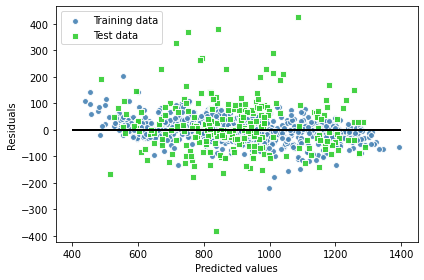

In [14]:
## 잔차그래프
plt.scatter(x2_train_pred, x2_train_pred - x2_train, c='steelblue', edgecolor='white', marker='o', s=35, alpha=0.9, label='Training data')
plt.scatter(x2_test_pred, x2_test_pred - x2_test, c='limegreen', edgecolor='white', marker='s', s=35, alpha=0.9, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=400, xmax=1400, lw=2, color='black')
plt.tight_layout()
plt.show()

## 랜덤포레스트_저녁 (파생변수 : 실제식사가능자수)

In [15]:
## 훈련데이터 분리
x1_train, x1_test, x2_train, x2_test = train_test_split(x_train, y2_train, test_size=0.2, random_state=1)

## 랜덤포레스트 (베이스라인)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42, criterion='mae')
model2.fit(x1_train, x2_train)
x2_train_pred = model1.predict(x1_train)
x2_test_pred = model1.predict(x1_test)

## 성능 평가 (R-squared 상관계수)
print('훈련 MAE: %.3f, 테스트 MAE: %.3f' %(mean_squared_error(x2_train, x2_train_pred), mean_squared_error(x2_test, x2_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' %(r2_score(x2_train, x2_train_pred), r2_score(x2_test, x2_test_pred)))

훈련 MAE: 213664.417, 테스트 MAE: 226461.891
훈련 R^2: -10.166, 테스트 R^2: -10.204


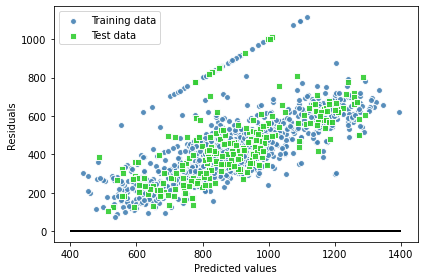

In [16]:
## 잔차그래프
plt.scatter(x2_train_pred, x2_train_pred - x2_train, c='steelblue', edgecolor='white', marker='o', s=35, alpha=0.9, label='Training data')
plt.scatter(x2_test_pred, x2_test_pred - x2_test, c='limegreen', edgecolor='white', marker='s', s=35, alpha=0.9, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=400, xmax=1400, lw=2, color='black')
plt.tight_layout()
plt.show()

## 추론

In [17]:
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)

In [18]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [19]:
submission.to_csv('baseline.csv', index=False)

In [20]:
submission = pd.read_csv('C:/Users/juyeo/Desktop/구내식당//sample_submission.csv')

In [21]:
submission

,일자,중식계,석식계
0,2021-01-27,1026.570,405.030
1,2021-01-28,972.200,397.480
2,2021-01-29,594.700,268.940
3,2021-02-01,1203.765,485.520
4,2021-02-02,958.410,461.190
5,2021-02-03,1002.170,402.930
6,2021-02-04,924.090,477.400
7,2021-02-05,596.850,341.310
8,2021-02-08,1170.835,646.470
9,2021-02-09,989.570,511.270
